## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.io import loadmat  # SciPy module to load .mat files

sns.set_style('darkgrid')

## Loading MNIST dataset

In [2]:
mnist = loadmat('mnist-dataset/mnist-original.mat')

In [3]:
# A sample of size 70.000 of 28x28 = 784pixels grayscale images
mnist['data'].shape

(784, 70000)

In [4]:
# Labels corresponding to each image
mnist['label'].shape

(1, 70000)

In [5]:
# Combining data and label in one dataframe
nb_pixels = mnist['data'].shape[0]
nb_images = mnist['data'].shape[1]

mnist_dataset = pd.DataFrame(mnist['data'].T)
mnist_dataset.columns = ['x_{index}'.format(index=i) for i in range(nb_pixels)]
mnist_dataset['label'] = mnist['label'].T.astype(int)

In [6]:
mnist_dataset.head()

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_775,x_776,x_777,x_778,x_779,x_780,x_781,x_782,x_783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


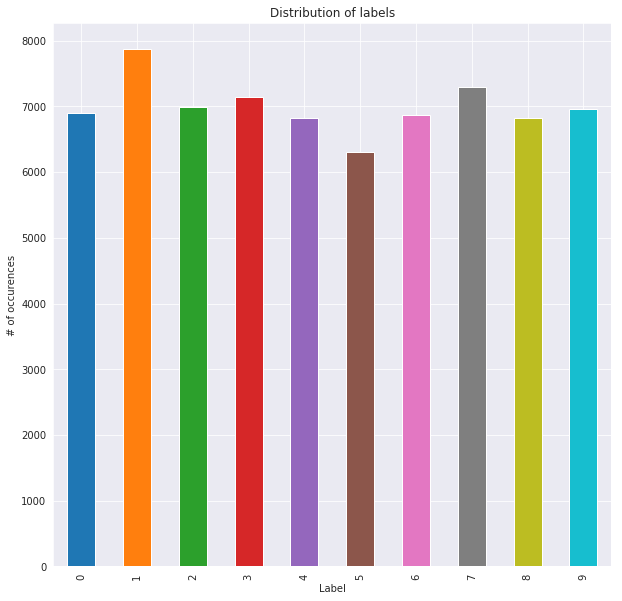

In [7]:
plt.rcParams['figure.figsize'] = (10, 10)
mnist_dataset['label'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of labels')
plt.xlabel('Label')
plt.ylabel('# of occurences')
plt.show()

### Selecting a sample of size = 10000 to work on

In [8]:
sample_size = 10000
mnist_dataset_sample = mnist_dataset.sample(n=sample_size, random_state=123)

In [9]:
data = mnist_dataset_sample.drop('label', 1)
label = mnist_dataset_sample['label']

## Data visualization

In [10]:
def plot_data(data, label, title='Label', size=12):
    plt.rcParams['figure.constrained_layout.use'] = True
    dataset_size = data.shape[0]
    label = pd.Series(label)
    # Converting and reshaping each row of the dataset as a 28x28 image to have a plottable array
    images = [
        data.iloc[i, :].values.reshape(28, 28) for i in range(dataset_size)
    ]

    # Selecting a random sample of size=12(by default) from the dataset
    select = np.random.randint(dataset_size, size=size)
    rows = np.floor(np.sqrt(size))
    cols = np.ceil(size / rows)
    
    # Plotting each image with its corresponding label
    for index, value in enumerate(select):
        plt.subplot(rows, cols, index + 1)
        plt.axis('off')
        plt.imshow(
            images[value],
            cmap=plt.cm.gray_r,
            interpolation="nearest")
        plt.title('{}: {}'.format(title, int(label.iloc[value])))

    plt.show()

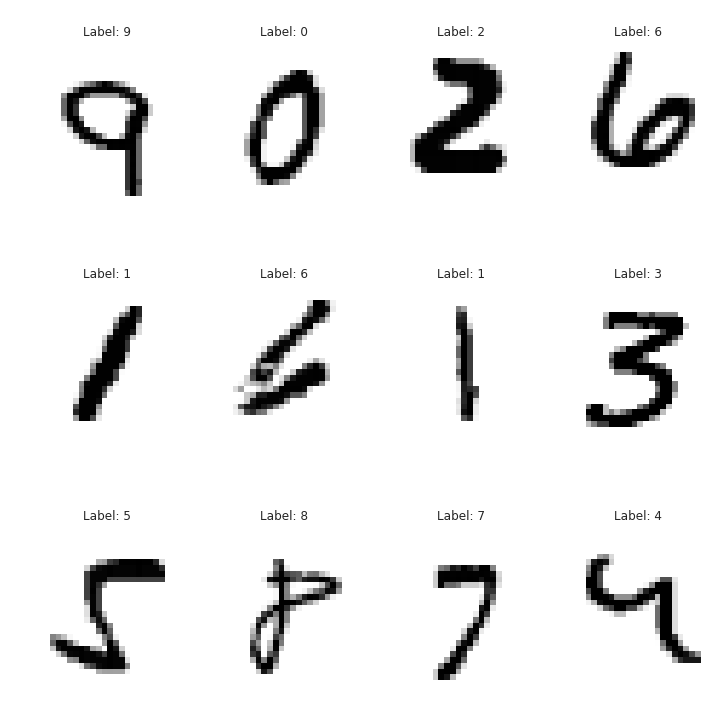

In [11]:
plot_data(data, label)

## Train/Test split and model fitting

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2)

### Utility functions

In [14]:
def pretty_print_cm(cm, labels, normalize=False):
    """pretty print confusion matrices"""
    import seaborn as sns
    from sklearn.preprocessing import scale
    
    title = 'Confusion matrix'
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = ' '.join(['Normalized', title])
    
    conf_mat = pd.DataFrame(cm, columns=labels, index=labels)
    conf_mat.index.name = 'True \ Predicted'
    ax = sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(title)
    plt.show()

In [15]:
def generate_prediction_results(y_true, y_pred):
    """generate classification report and confusion matrix on a given true and predicted values"""
    from sklearn.metrics import classification_report, confusion_matrix

    conf_mat = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred, output_dict=True)
    return conf_mat, class_report

In [ ]:
test_sample_size = len(y_test)

misclass_images_indices = [
    index for index in range(test_sample_size)
    if not y_test.iloc[index] == predictions[index]
]
misclass_images = X_test.iloc[misclass_images_indices]
predicted_labels = predictions[misclass_images_indices]

plot_data(misclass_images, predicted_labels, 'Predicted')

## Fitting SVM

In [16]:
from sklearn.svm import SVC

clf = SVC(gamma='scale')
clf.fit(X_train, y_train)
SVM_predictions_train = clf.predict(X_train)
SVM_predictions_test = clf.predict(X_test)

### Training results

In [19]:
SVM_confusion_matrix_train, SVM_classification_report_train = generate_prediction_results(
    y_train, SVM_predictions_train)

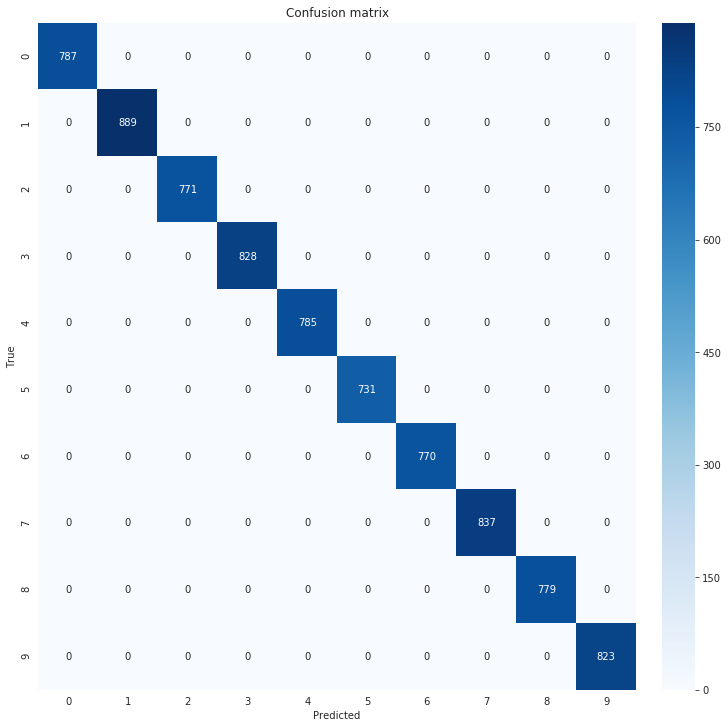

In [20]:
# Confusion matrix
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
pretty_print_cm(SVM_confusion_matrix_train, labels)

In [21]:
# Classification report
pd.DataFrame(SVM_classification_report_train)

,0,1,2,3,4,5,6,7,8,9,macro avg,micro avg,weighted avg
f1-score,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
precision,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
support,787.0,889.0,771.0,828.0,785.0,731.0,770.0,837.0,779.0,823.0,8000.0,8000.0,8000.0


### Testing results

In [22]:
SVM_confusion_matrix_test, SVM_classification_report_test = generate_prediction_results(y_test, SVM_predictions_test)

/home/whitenoise/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/whitenoise/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/whitenoise/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


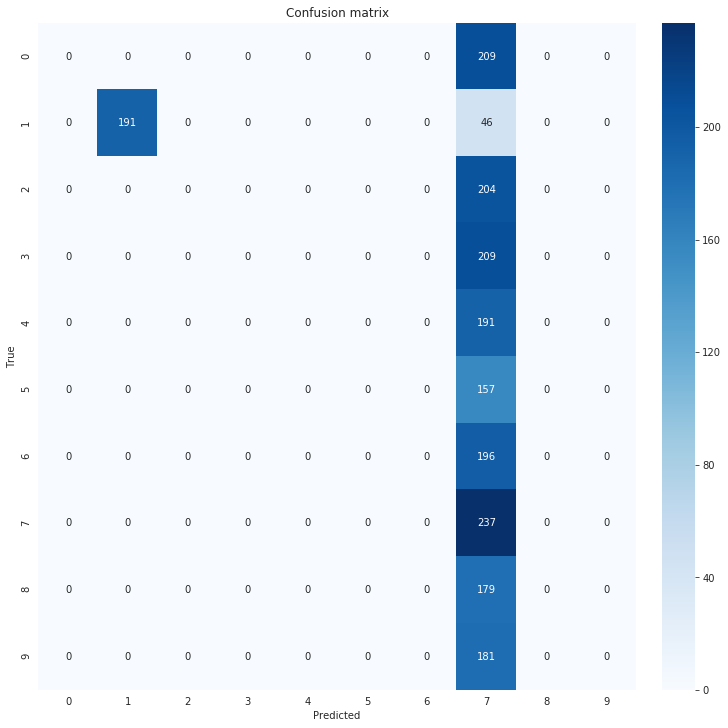

In [23]:
# Confusion matrix
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
pretty_print_cm(SVM_confusion_matrix_test, labels)

In [24]:
pd.DataFrame(SVM_classification_report_test)

,0,1,2,3,4,5,6,7,8,9,macro avg,micro avg,weighted avg
f1-score,0.0,0.892523,0.0,0.0,0.0,0.0,0.0,0.231672,0.0,0.0,0.112419,0.214,0.133217
precision,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.131012,0.0,0.0,0.113101,0.214,0.134025
recall,0.0,0.805907,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.180591,0.214,0.214000
support,209.0,237.000000,204.0,209.0,191.0,157.0,196.0,237.000000,179.0,181.0,2000.000000,2000.000,2000.000000


<p>The SVM has performed poorly. It has overfitted the training set. We're going to fit in the next paragraph an ordinary Neural Net and compare the results.</p>

## Fitting NNet

In [25]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier()
clf.fit(X_train, y_train)
MLP_predictions_train = clf.predict(X_train)
MLP_predictions_test = clf.predict(X_test)

### Training results

In [26]:
MLP_confusion_matrix_train, MLP_classification_report_train = generate_prediction_results(
    y_train, MLP_predictions_train)

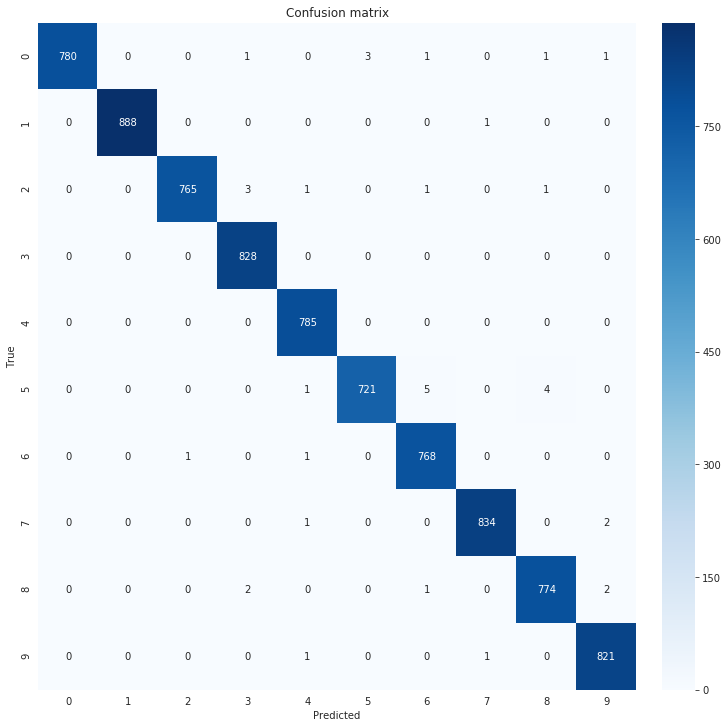

In [27]:
# Confusion matrix
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
pretty_print_cm(MLP_confusion_matrix_train, labels)

In [28]:
# Classification report
pd.DataFrame(MLP_classification_report_train)

,0,1,2,3,4,5,6,7,8,9,macro avg,micro avg,weighted avg
f1-score,0.995533,0.999437,0.995446,0.996390,0.996825,0.991065,0.993532,0.997011,0.992944,0.995755,0.995394,0.9955,0.995498
precision,1.000000,1.000000,0.998695,0.992806,0.993671,0.995856,0.989691,0.997608,0.992308,0.993947,0.995458,0.9955,0.995516
recall,0.991105,0.998875,0.992218,1.000000,1.000000,0.986320,0.997403,0.996416,0.993582,0.997570,0.995349,0.9955,0.995500
support,787.000000,889.000000,771.000000,828.000000,785.000000,731.000000,770.000000,837.000000,779.000000,823.000000,8000.000000,8000.0000,8000.000000


### Testing results

In [29]:
MLP_confusion_matrix_test, MLP_classification_report_test = generate_prediction_results(
    y_test, MLP_predictions_test)

In [ ]:
# Confusion matrix
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
pretty_print_cm(MLP_confusion_matrix_test, labels)

In [67]:
# Classification report
pd.DataFrame(MLP_classification_report_test)

,0,1,2,3,4,5,6,7,8,9,macro avg,micro avg,weighted avg
f1-score,0.963325,0.961864,0.931442,0.905660,0.908163,0.897507,0.952646,0.933985,0.857939,0.877551,0.919008,0.9205,0.920314
precision,0.960976,0.961864,0.933649,0.914286,0.885572,0.890110,0.955307,0.918269,0.875000,0.895833,0.919087,0.9205,0.920461
recall,0.965686,0.961864,0.929245,0.897196,0.931937,0.905028,0.950000,0.950249,0.841530,0.860000,0.919274,0.9205,0.920500
support,204.000000,236.000000,212.000000,214.000000,191.000000,179.000000,180.000000,201.000000,183.000000,200.000000,2000.000000,2000.0000,2000.000000


<p>The ordinary NNet has performed better than the SVM.</p>